In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras as keras
from keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam

2024-07-10 09:07:25.745262: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 09:07:25.745310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 09:07:25.746125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 09:07:25.750116: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 09:07:26.387616: W tensorflow/compiler/tf2

**Creating the test and train dataset**

In [2]:
path_to_data = './Bone Break Classification'

In [43]:
train_data=utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40,
)

Found 1129 files belonging to 10 classes.
Using 1017 files for training.


In [48]:
val_data=utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40,
)

Found 1129 files belonging to 10 classes.
Using 112 files for validation.


In [40]:
for images,lables in train_data.take(1):
  print('Amount of train images: ', images.shape)
  print('Amount of train labels: ', lables.shape)

Amount of train images:  (64, 256, 256, 3)
Amount of train labels:  (64,)


In [41]:
for images,lables in val_data.take(1):
  print('Amount of validation images: ', images.shape)
  print('Amount of validation labels: ', lables.shape)

Amount of validation images:  (64, 256, 256, 3)
Amount of validation labels:  (64,)


**Pre-Processing**

In [45]:
classes=train_data.class_names
print('The following classes are in the dataset:')
print(classes)

The following classes are in the dataset:
['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [46]:
def normalize(image, label):
  return image/255.0, label

In [49]:
train_data = train_data.map(normalize)
val_data= val_data.map(normalize)

**Test and Train**

In [14]:
train_x=[]
train_y=[]

for image,label in train_data:
   train_x.append(image)
   train_y.append(label)

train_x = tf.concat(train_x, axis=0)
train_y = tf.concat(train_y, axis=0)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


2024-07-10 09:09:12.169217: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 799801344 exceeds 10% of free system memory.


In [16]:
train_x

<tf.Tensor: shape=(1017, 256, 256, 3), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.       

In [17]:
val_x=[]
val_y=[]

for image,label in train_data:
   val_x.append(image)
   val_y.append(label)

val_x = tf.concat(val_x, axis=0)
val_y = tf.concat(val_y, axis=0)

2024-07-10 09:09:44.550324: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 799801344 exceeds 10% of free system memory.


**One Hot Encoding for categorical data**

In [20]:
num_classes = 10
train_y = tf.keras.utils.to_categorical(train_y, num_classes=num_classes)
val_y = tf.keras.utils.to_categorical(val_y, num_classes=num_classes)

**Take a look at the data**

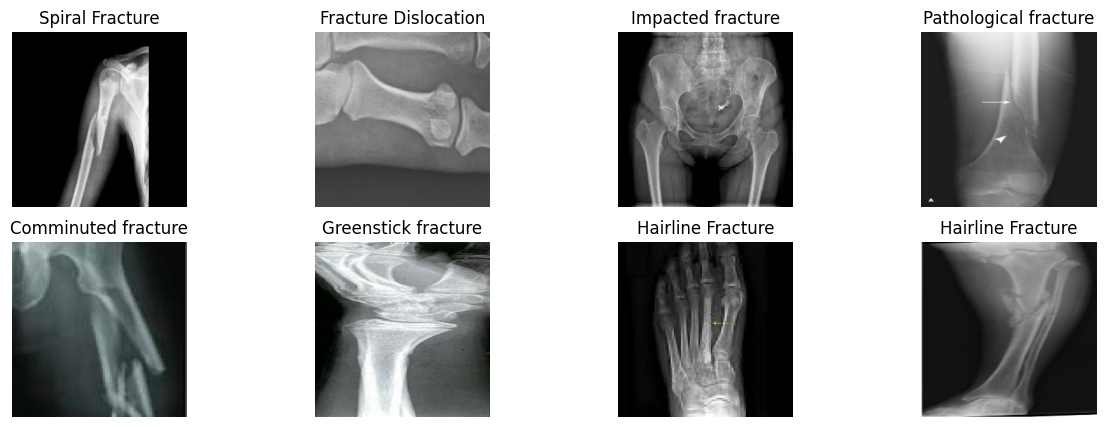

In [21]:
class_labels=["Avulsion fracture","Comminuted fracture","Fracture Dislocation","Greenstick fracture",
              "Hairline Fracture","Impacted fracture","Longitudinal fracture","Oblique fracture",
              "Pathological fracture","Spiral Fracture"]

fig, axes = plt.subplots(2, 4, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    image, label = train_x[i], train_y[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"{class_labels[np.argmax(label)]}")
    ax.axis('off')
    
plt.show()

**Convolutional Neural Network**

In [22]:
model = Sequential()
model.add(Conv2D(60, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(120, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 60)      1680      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 60)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 120)     64920     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 120)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 461280)            0         
                                                                 
 dense (Dense)               (None, 40)                1

In [24]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Training the model**

In [25]:
model.fit(train_x, train_y, batch_size=10, epochs=5,
          validation_data=(val_x,val_y))

Epoch 1/5


2024-07-10 09:10:30.102230: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154838400 exceeds 10% of free system memory.


  1/102 [..............................] - ETA: 1:35 - loss: 2.3212 - accuracy: 0.2000

2024-07-10 09:10:30.469792: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154838400 exceeds 10% of free system memory.
2024-07-10 09:10:30.601987: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154838400 exceeds 10% of free system memory.


102/102 [==============================] - 54s 521ms/step - loss: 2.5460 - accuracy: 0.1436 - val_loss: 2.2361 - val_accuracy: 0.1878
Epoch 2/5
102/102 [==============================] - 52s 511ms/step - loss: 2.1577 - accuracy: 0.2606 - val_loss: 1.8420 - val_accuracy: 0.4907
Epoch 3/5
102/102 [==============================] - 52s 510ms/step - loss: 1.5888 - accuracy: 0.4887 - val_loss: 1.2493 - val_accuracy: 0.5841
Epoch 4/5
102/102 [==============================] - 52s 510ms/step - loss: 0.9864 - accuracy: 0.7158 - val_loss: 0.5045 - val_accuracy: 0.8899
Epoch 5/5
102/102 [==============================] - 52s 510ms/step - loss: 0.4930 - accuracy: 0.8810 - val_loss: 0.2654 - val_accuracy: 0.9430


In [26]:
loss, accuracy = model.evaluate(val_x,val_y)
print('Test accuracy:', accuracy)

32/32 [==============================] - 7s 225ms/step - loss: 0.2654 - accuracy: 0.9430
Test accuracy: 0.9429695010185242


In [27]:
pred = model.predict(val_x)
print(pred)

32/32 [==============================] - 8s 230ms/step
[[1.83428500e-15 2.83031795e-07 1.11417615e-16 ... 9.99999702e-01
  5.18253138e-08 2.13025347e-14]
 [5.86115904e-02 5.94945312e-01 3.31873782e-02 ... 2.51542572e-02
  2.50057802e-02 7.70904636e-03]
 [1.38585350e-16 7.34084148e-12 2.32907061e-17 ... 3.74604285e-14
  9.99999940e-01 3.22333878e-15]
 ...
 [1.19590426e-04 4.50260588e-04 8.09574907e-04 ... 1.46335049e-04
  8.29106193e-06 1.60368529e-06]
 [6.25895942e-03 1.19312688e-04 5.99076599e-03 ... 2.71146069e-03
  9.69134390e-01 1.09078009e-02]
 [5.47676049e-02 3.71586735e-04 9.31224823e-01 ... 1.61002902e-03
  4.67599457e-04 7.94519263e-04]]


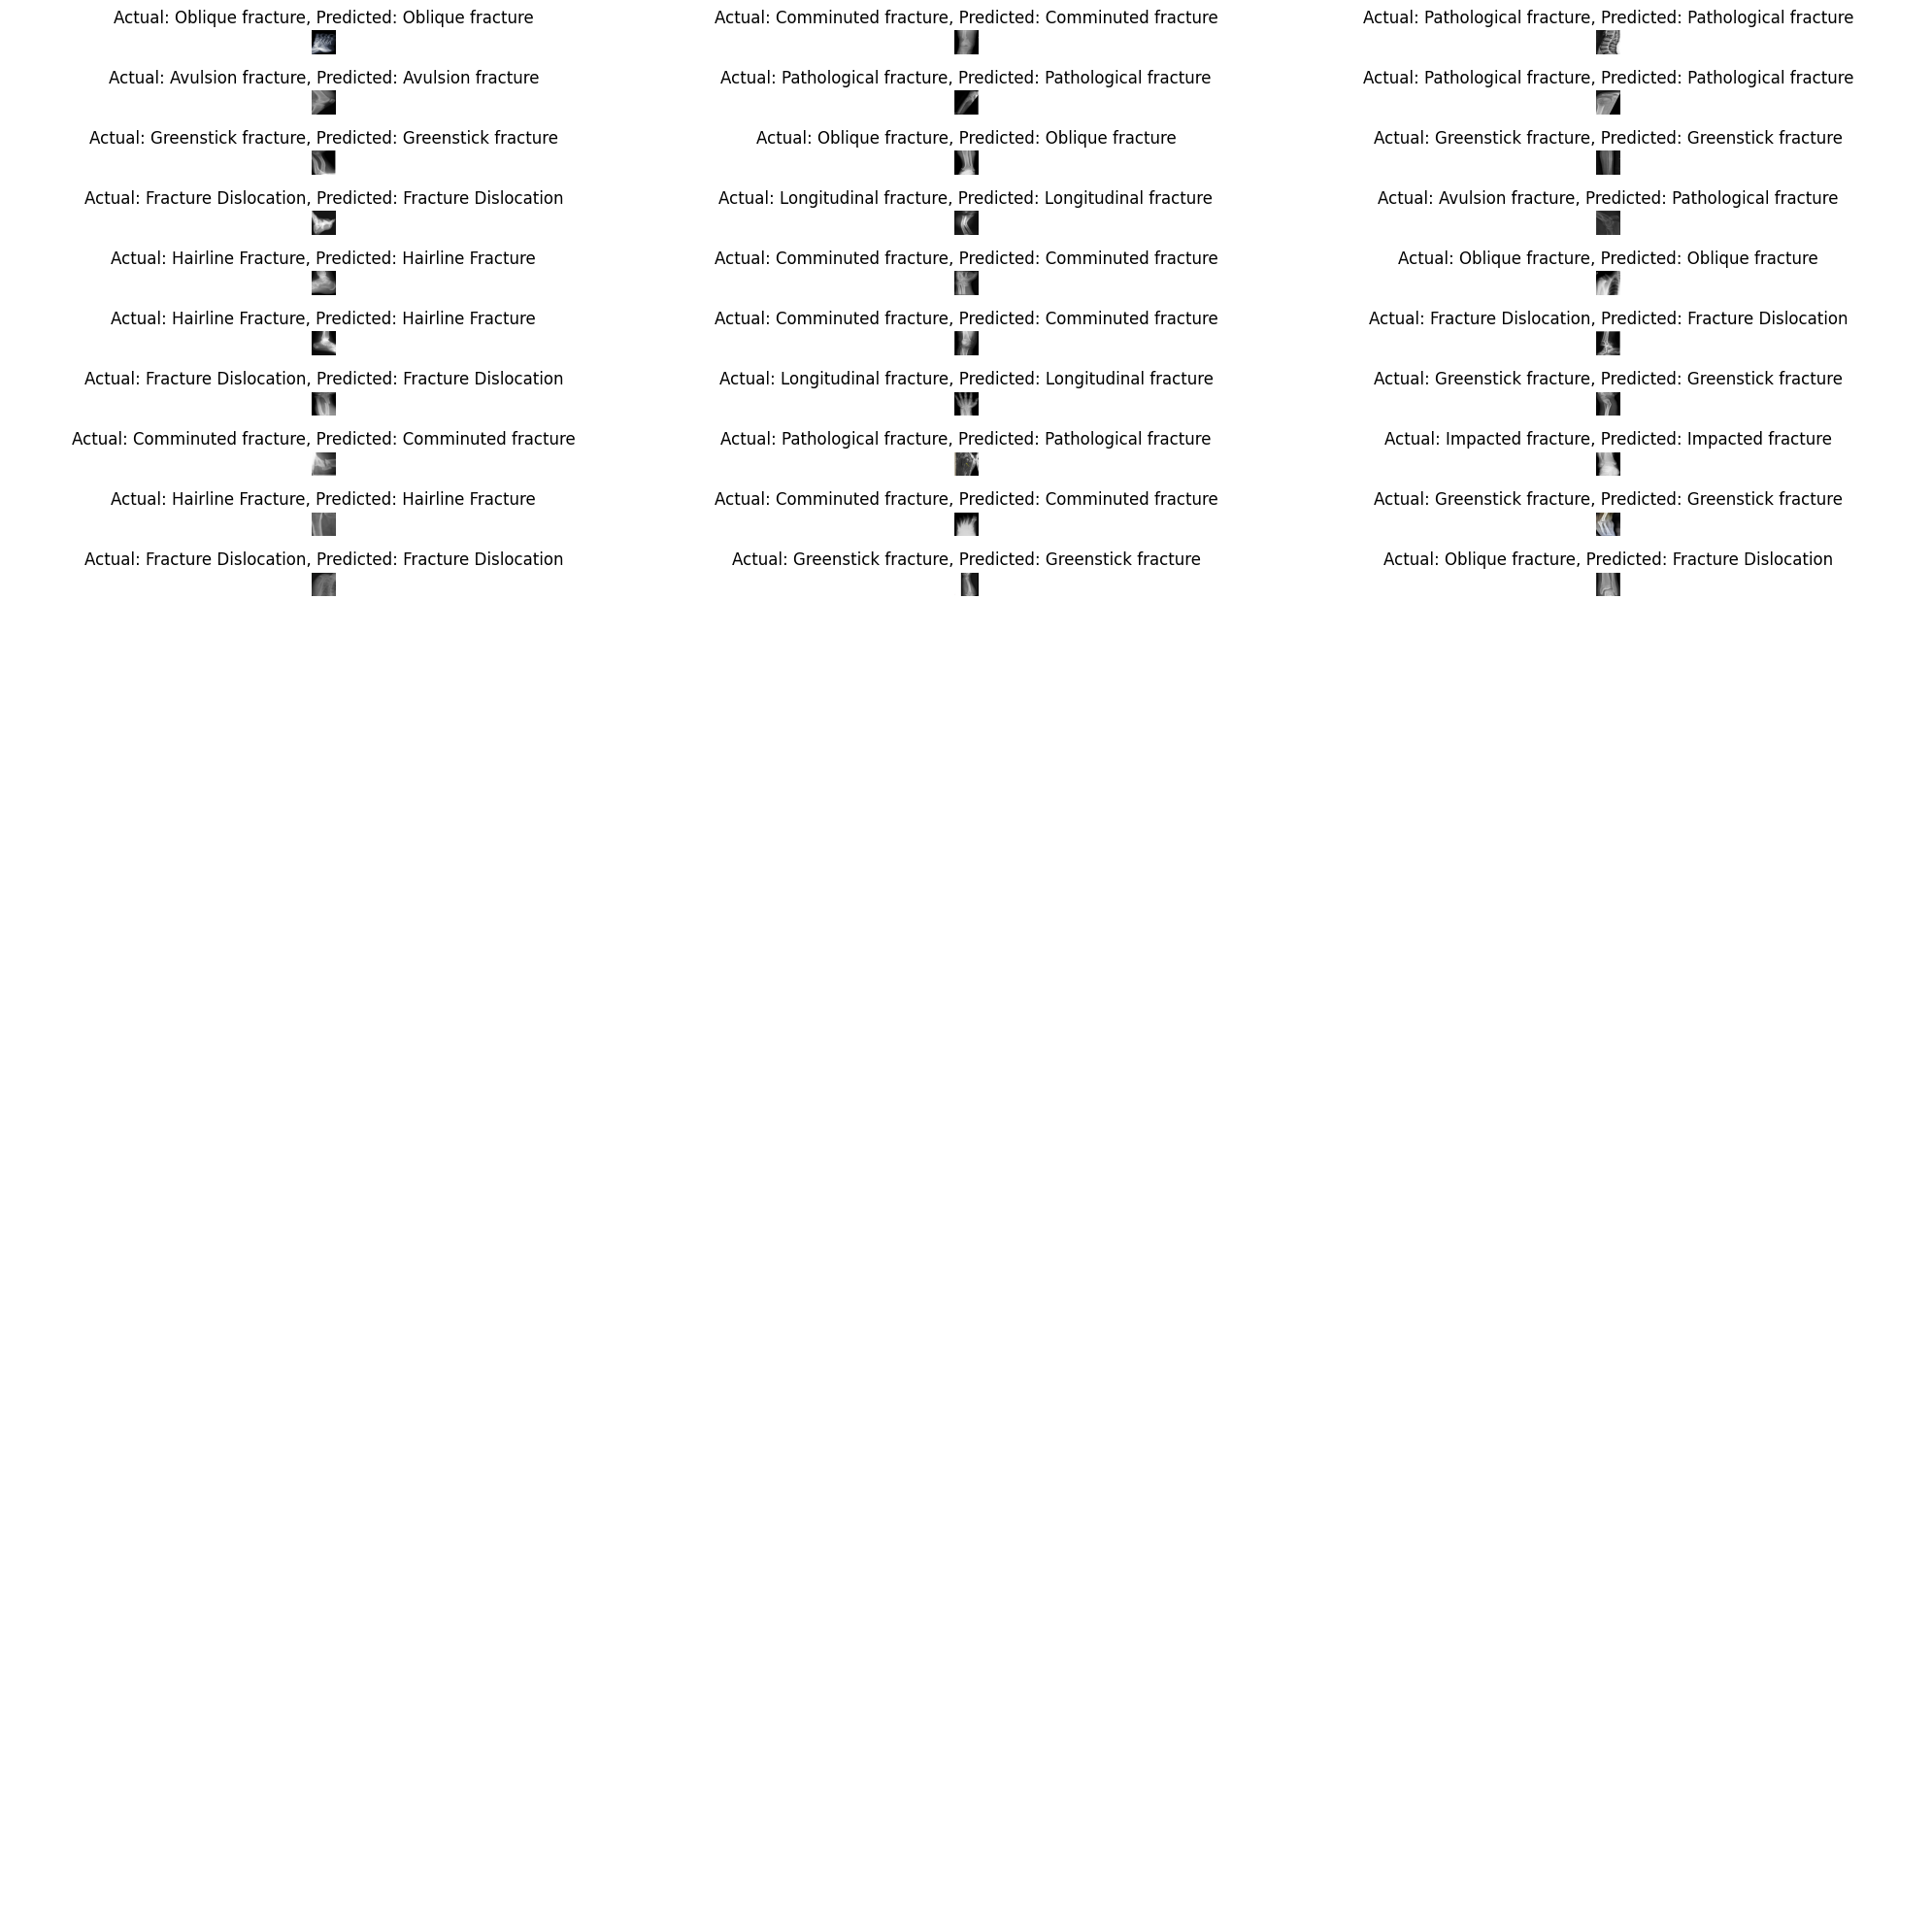

In [28]:
num_images_to_display = 30
num_columns = 3
num_rows = (num_images_to_display + num_columns - 1) 

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    if i < num_images_to_display:
        ax.imshow(val_x[i])
        actual_label = class_labels[np.argmax(val_y[i])]
        predicted_label = class_labels[np.argmax(pred[i])]
        ax.set_title(f"Actual: {actual_label}, Predicted: {predicted_label}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()